In [1]:
from starter_code import (
    ani1_config,
    load_ani1_data,
    calc_resid,
    create_heatmap,
    create_boxplot,
    filter_outliers,
    create_histogram,
    num_heavy_atoms
)

## Load ANI-1 Data

In [2]:
molecules = load_ani1_data()
# Calculate the residual vector for each method-method combination
resid = calc_resid(molecules)
# Resid but as a Dataframe
resid_df = calc_resid(molecules, as_dataframe=True)

data file path is ./ANI-1ccx_clean_fullentry.h5


Calculating residuals: 100%|██████████| 91/91 [00:36<00:00,  2.47it/s]


In [3]:
# Filtering Data
filtered_data = filter_outliers(data_matrix=resid)
filtered_data_df = filter_outliers(dataframe=resid_df)

Correct for number of heavy atoms (/ by sqrt(heavy atoms)

In [4]:
# for index in resid_df.index:
#     index = index[0]
#     nh = num_heavy_atoms(index)
#     resid_df.loc[index] = resid_df.loc[index] / (nh ** 0.5)

for index in filtered_data_df.index:
    index = index[0]
    nh = num_heavy_atoms(index)
    filtered_data_df.loc[index] = filtered_data_df.loc[index] / (nh ** 0.5)

In [5]:
print(filtered_data_df)

               (dt, cc) (dt, hd) (dt, hq) (dt, ht) (dt, md) (dt, mq) (dt, mt)  \
name   iconfig                                                                  
C1H1N1 0            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
       1            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
       2            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
       3            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
       4            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
...                 ...      ...      ...      ...      ...      ...      ...   
O3     55           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
       56           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
       57           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
       58           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
       59           NaN     

### MAE Heatmaps

Here we plot the MAE between quantum chemical methods in a heatmap.

100%|██████████| 91/91 [00:00<00:00, 943.43it/s]


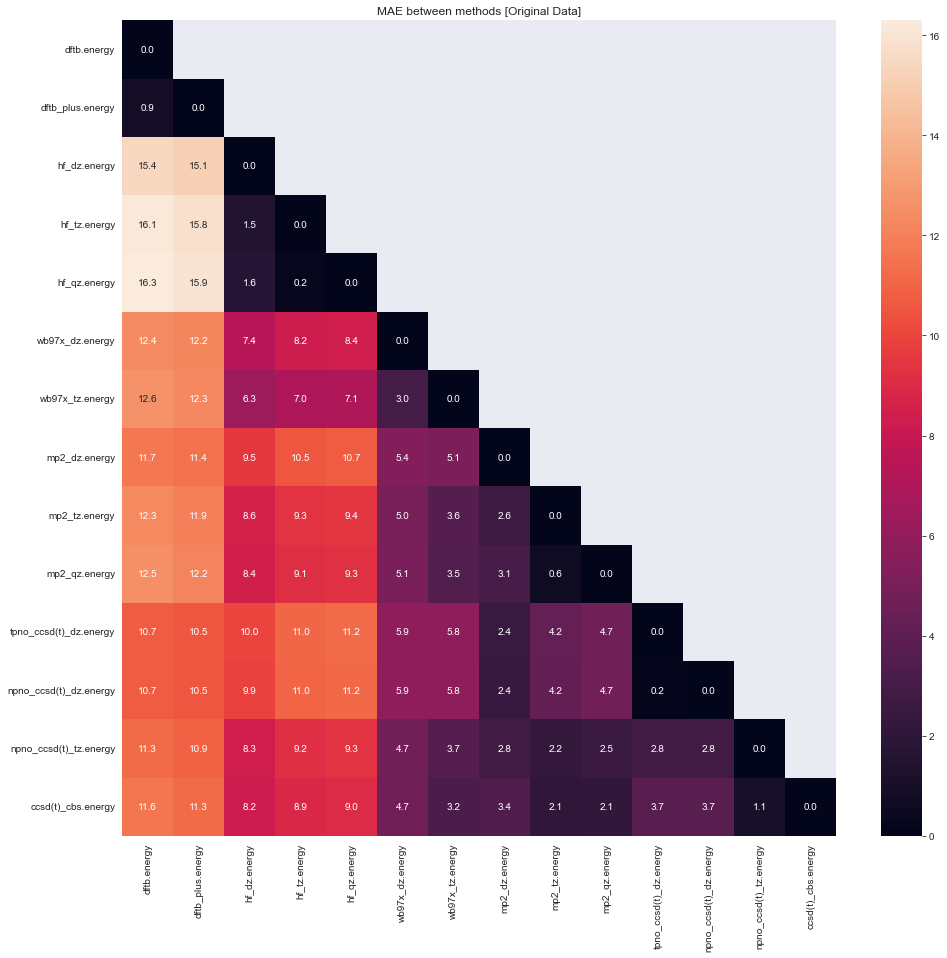

  0%|          | 0/91 [00:00<?, ?it/s]


KeyError: '(0, 1)'

In [12]:
import seaborn as sns
# Create a heatmap of the MAE between methods
#heatmap_fmt = {"annot_kws": {'size': 16}}
# create_heatmap(ani1_config["target"], "MAE between methods [Original Data]", data_matrix=resid, show_progress=True)
# Heatmap with filtered data
create_heatmap(
        ani1_config["target"],
        "MAE between methods [FILTERED Data]",
        # data_matrix=filtered_data,
        dataframe=filtered_data_df,
        show_progress=True
    )

# Outlier Exploration
## Data Spread

In [ ]:
# Original data boxplot
create_boxplot(resid, "Original Data Spread", method="dt")
# Filtered data boxplot
create_boxplot(filtered_data, "Filtered Data Spread", "dt")

## Heatmap of Number of Outliers

We concluded that using IQRs were too aggressive, so used 20 SDs instead.

In [ ]:
print(resid_df['td', 'nd'].size)
print(filtered_data_df['td', 'nd'].size)

100%|██████████| 91/91 [00:00<00:00, 919.33it/s]


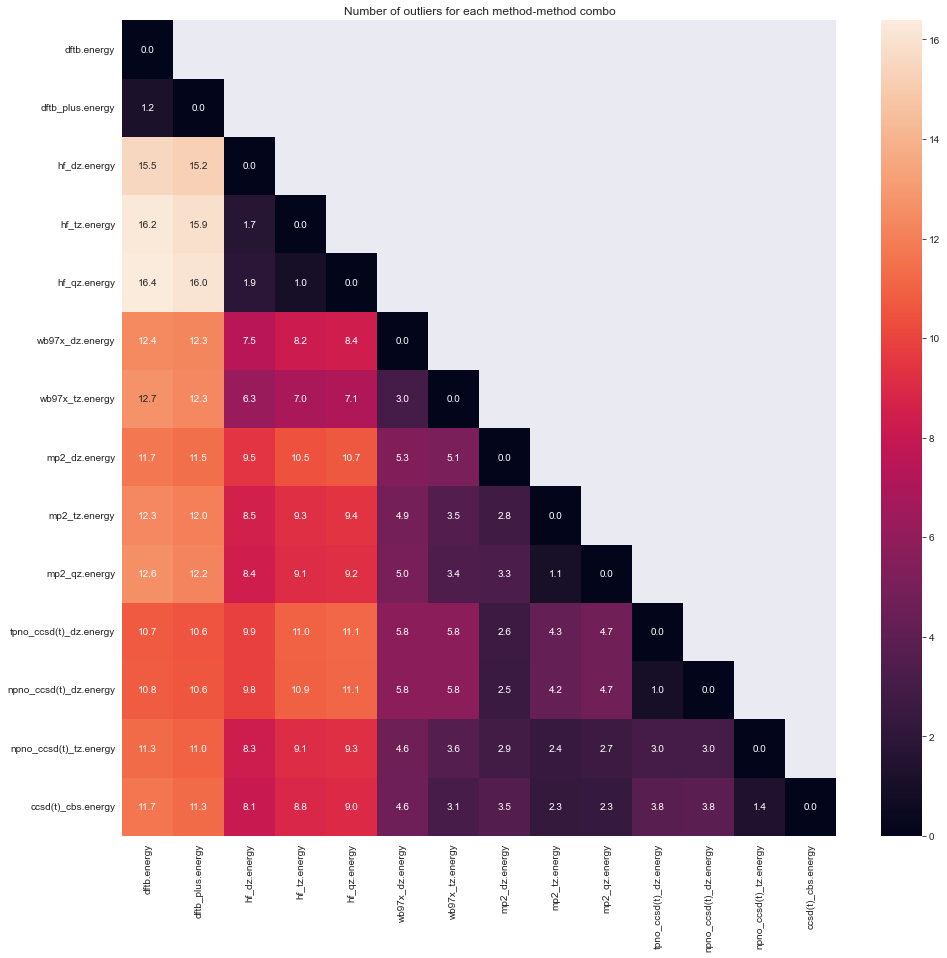

In [8]:
# Get number of outliers
n_outliers = {}
for (target_1, target_2) in resid:
    # Dictionary
    # n_outliers[target_1, target_2] = len(resid[target_1, target_2]) - len(filtered_data[target_1, target_2])
    # Dataframes
    n_outliers[target_1, target_2] = resid_df[target_1, target_2].size - filtered_data_df[target_1, target_2].size
    # Difference in the number of outliers
    # n_outliers[target_1, target_2] = resid_df[target_1, target_2] - filtered_data_df[target_1, target_2]
# Plot
create_heatmap(
    ani1_config["target"],
    "Number of outliers for each method-method combo",
    data_matrix=n_outliers,
    show_progress=True
)
# okay to use create_heatmap since mean of 1 number is just the number

## Histograms for Outlier Molecule Frequency
In this section, we're interested to see if there are particular molecules that tend to be outliers more frequently than others.

To do this, we generate a histogram of the frequency at which a molecule appears as an outlier for a method-method pair.

In [4]:
data = filtered_data_df.groupby(level=[0]).sum()


# Optionally order the molecules by the mean of the outlier count for each method-method pair
data = data.loc[data.mean(axis="columns").sort_values(ascending=False).index, :]

In [ ]:
create_histogram(data.iloc[0:10]) # y axis is # of methods while x-axis is MAE

In [ ]:
create_histogram(data.iloc[-10:-1])

Plot histograms of the percentage of molecular configurations which are outliers

In [6]:
data = filter_outliers(dataframe=resid_df).groupby(level=[0]).mean()

# Optionally order the molecules by the mean of the outlier proportion for each method-method pair
data = data.loc[data.mean(axis="columns").sort_values(ascending=False).index, :]

In [ ]:
create_histogram(data.iloc[0:10])

In [ ]:
create_histogram(data.iloc[-10:-1])

# Correcting for the Number of Heavy Atoms

This did not yield anything interesting or significant.

In [ ]:
# add number of heavy atoms as a column ('nh')
nh_column = []
for index in resid_df.index:
    nh = num_heavy_atoms(str(index))
    nh_column.append(nh)

resid_df['nh'] = nh_column
data = resid_df.sort_values(by=['nh'])
print(data)
original_data = filter_outliers(dataframe=resid_df).groupby(level=[0]).sum()
print(original_data)

In [ ]:
import pandas as pd
df = pd.DataFrame()
n_sd = 20
for i in range(data['nh'].max()):
    nh_data = data.loc[data['nh'] == (i+1)] / (i+1) # divide by number of heavy atoms
    print(nh_data)
    upper_bound = nh_data.mean() + n_sd * nh_data.std()
    lower_bound = nh_data.mean() - n_sd * nh_data.std()
    nh_data = (nh_data < upper_bound) & (nh_data > lower_bound)
    print(nh_data)
    df = pd.concat([df, nh_data])

df = df.drop(['nh'], axis=1)
print(df.groupby(level=[0]).sum())